<a href="https://colab.research.google.com/github/tasty-orange/ARN-labs/blob/main/ARN_PW3_Piemontesi_Trueb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Work 3 ARN - G.Piemontesi & G.Trueb

##Première expérience : Classification « awake » / « asleep »

Dans cette expérience, nous allons classifier les états « awake » (éveillé) et « asleep » (endormi) des souris en regroupant les phases n-rem et rem sous « asleep ». L'objectif est de créer un modèle MLP pour prédire ces deux états à partir des données EEG des souris. Nous évaluerons les performances du modèle à l'aide de la perte d'entraînement, de la validation, de la matrice de confusion et du F1-score.

### Import des packages/dépendances



In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from collections import Counter
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import regularizers
from tensorflow import keras

### Import des données des souris

In [2]:
# Chargement des données d'entraînement
mice_eeg_1 = pd.read_csv('EEG_mouse_data_1.csv')
mice_eeg_2 = pd.read_csv('EEG_mouse_data_2.csv')

# Fusion des deux jeux de données d'entraînement
data_training = pd.concat([mice_eeg_1, mice_eeg_2])

# Chargement des données de test
data_test = pd.read_csv('EEG_mouse_data_test.csv')

###Preprocessing et normalisation des données

Comme on peut le voir dans le diagramme en barres ci-dessous, nous avons trois états pour le sommeil des souris, et nous voulons n'en avoir que deux : 'awake' et 'asleep'.

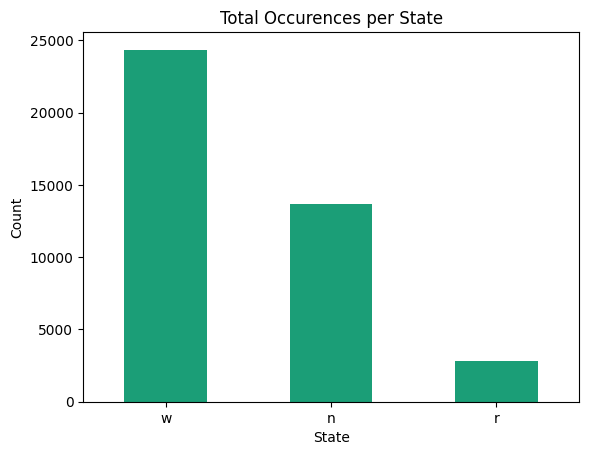

In [3]:
data_training.state.value_counts().plot(kind='bar', cmap='Dark2')
plt.title('Total Occurences per State')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('State');

Modification du dataset pour fusionner les états 'n' et 'r' en un seul pour 'asleep', afin de n'avoir plus que les états 'awake' et 'asleep'.

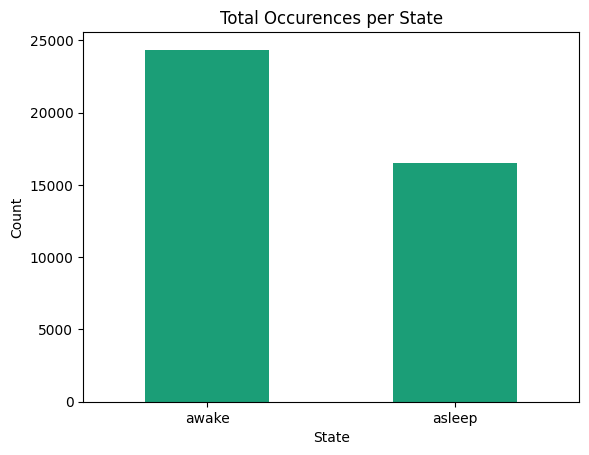

In [4]:
# Modifier la variable cible 'state' pour n'avoir que deux classes : 'awake' et 'asleep'
data_training['state'] = data_training['state'].replace({'w': 'awake', 'r': 'asleep', 'n': 'asleep'})
data_training.state.value_counts().plot(kind='bar', cmap='Dark2')
plt.title('Total Occurences per State')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('State');

In [5]:
# Séparer les caractéristiques et la variable cible
input_data = data_training.drop('state', axis=1).values
output_data = data_training['state'].values

# Garder seulement les 25 premières caractéristiques
input_data = input_data[:, :25]

# Normaliser les données d'entrée
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

# Encoder la variable cible
encoder = LabelEncoder()
output_data = encoder.fit_transform(output_data)

# Définir KFold
kf = KFold(n_splits=3, shuffle=True, random_state=1)

### Creation du modèle MLP


In [8]:

def create():
    model = Sequential([
        # Entrée avec les 25 caractéristiques
        Input(shape=(25,)),

        # Première couche cachée avec régularisation L2
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        # Deuxième couche cachée avec régularisation L2
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        # Dropout pour éviter le surapprentissage, 30% des neurones sont mis à zéro durant l'entraînement
        Dropout(0.3),

        # Couche de sortie
        Dense(1, activation='sigmoid')
    ])

    # Compiler le modèle avec l'optimiseur Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

# Afficher le modèle
model = create()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 64)                  │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,777 (14.75 KB)

 Trainable params: 3,777 (14.75 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du modèle

In [9]:
# Stockage des métriques
train_losses = []
val_losses = []
f1_scores = []
conf_matrices = []

# Entraînement du modèle avec validation croisée
for fold, (train_index, val_index) in enumerate(kf.split(input_data)):
    X_train, X_val = input_data[train_index], input_data[val_index]
    y_train, y_val = output_data[train_index], output_data[val_index]

    model = create()

    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

    # Stocker les pertes
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Prédictions sur l'ensemble de validation
    y_pred = model.predict(X_val)
    y_pred = (y_pred > 0.5).astype(int)

    # Matrice de confusion
    cm = confusion_matrix(y_val, y_pred)
    conf_matrices.append(cm)

    # Calcul du F1-score
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8505 - loss: 0.4273 - val_accuracy: 0.8886 - val_loss: 0.3260
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8869 - loss: 0.3297 - val_accuracy: 0.8912 - val_loss: 0.3048
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8881 - loss: 0.3140 - val_accuracy: 0.8924 - val_loss: 0.2941
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8919 - loss: 0.3031 - val_accuracy: 0.8914 - val_loss: 0.2917
Epoch 5/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8902 - loss: 0.2951 - val_accuracy: 0.8916 - val_loss: 0.2863
Epoch 6/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8929 - loss: 0.2948 - val_accuracy: 0.8904 - val_loss: 0.2847
Epoch 7/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8952 - loss: 0.2867 - val_accuracy: 0.8924 - val_loss: 0.2811
Epoch 8/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8961 - loss: 0.2802 - val_accuracy: 0.

### Évaluation du modèle

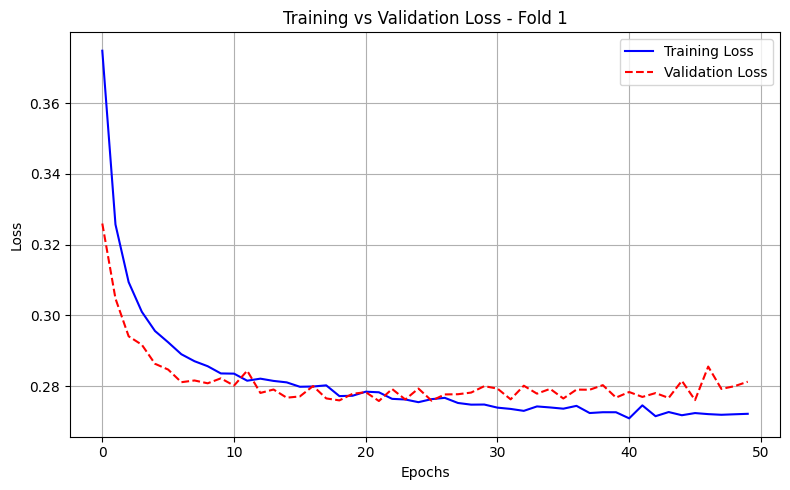

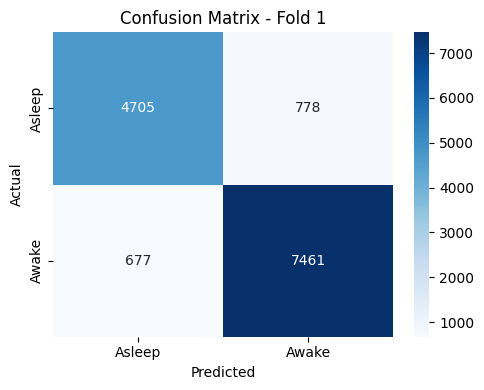

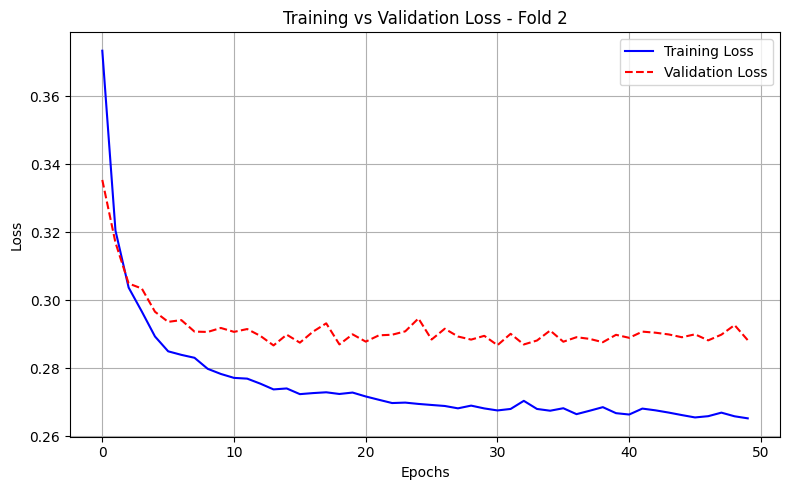

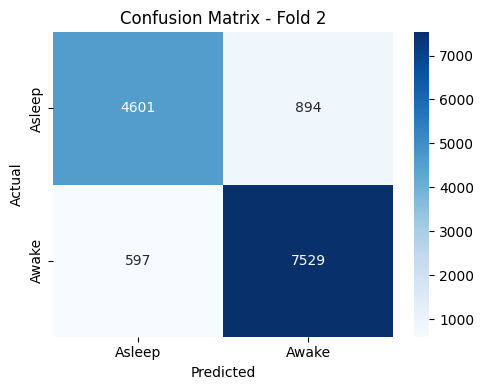

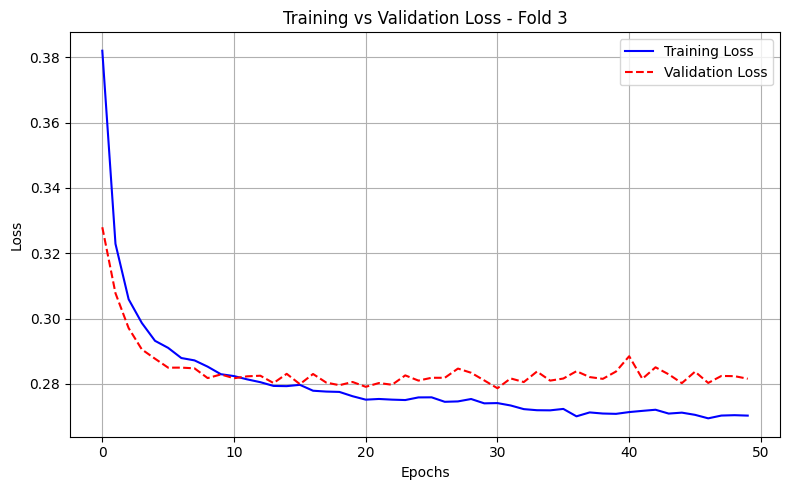

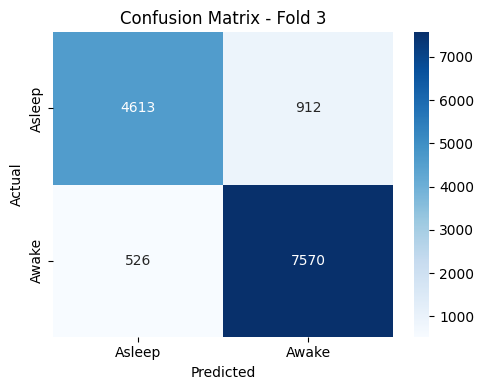


F1-score moyen final : 0.9114


In [12]:
# Affichage des courbes de perte séparément par fold
for fold in range(3):
    # Courbe de perte
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses[fold], label='Training Loss', color='blue')
    plt.plot(val_losses[fold], label='Validation Loss', color='red', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training vs Validation Loss - Fold {fold+1}')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Ajuste les espaces entre les graphiques pour éviter les chevauchements
    plt.show()

    # Matrice de confusion
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrices[fold], annot=True, fmt='d', cmap='Blues', xticklabels=['Asleep', 'Awake'], yticklabels=['Asleep', 'Awake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.tight_layout()  # Ajoute de l'espace entre la matrice et les axes
    plt.show()

# Affichage du F1-score moyen final
mean_f1 = np.mean(f1_scores)
print(f'\nF1-score moyen final : {mean_f1:.4f}')
